In [1]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn
import optax
import scipy

In [2]:
import matplotlib.pyplot as plt

In [3]:
# We create one dense layer instance (taking 'features' parameter as input)

class ExplicitMLP(nn.Module):
    features: Sequence[int]
    lb = jnp.array([0.0,-1.0])
    ub = jnp.array([1.0,1.0])

    def setup(self):
    # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

    def __call__(self, inputs,lb=lb,ub=ub):
       # print(ub,lb)
        x = 2.0*(inputs-lb)/(ub-lb) - 1.0
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.tanh(x)
        return x
#model = nn.Dense(features=5)

In [4]:
model =  ExplicitMLP(features=[20,20,20,20,20,20,20,20,1])
key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (1,2)) # Dummy input data

In [5]:
params = model.init(key2,x)

In [6]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'layers_0': {'bias': (20,), 'kernel': (2, 20)},
  'layers_1': {'bias': (20,), 'kernel': (20, 20)},
  'layers_2': {'bias': (20,), 'kernel': (20, 20)},
  'layers_3': {'bias': (20,), 'kernel': (20, 20)},
  'layers_4': {'bias': (20,), 'kernel': (20, 20)},
  'layers_5': {'bias': (20,), 'kernel': (20, 20)},
  'layers_6': {'bias': (20,), 'kernel': (20, 20)},
  'layers_7': {'bias': (20,), 'kernel': (20, 20)},
  'layers_8': {'bias': (1,), 'kernel': (20, 1)}}}

In [7]:
n_samp = 100
xdim = 2
fdim = 1

pi = jnp.pi

key = jax.random.PRNGKey(0)
key1,key2 = jax.random.split(key)
#W = jax.random.normal(key1,(xdim,ydim))
#b = jax.random.normal(key2,(ydim,))
pi

3.141592653589793

In [8]:
def get_bndry(x_min=-1.0,x_max=1.0,xn=100,t_min=0.0,t_max=1.0,tn=100):
    x = jnp.linspace(x_min,x_max,xn)
    t = jnp.zeros_like(x)
    d_ini = jnp.stack((t,x),axis=1)
    
    xnh = int(1.0*xn/2.0)
    
    f_ini = jnp.cos(pi*x)
    
   
    
    
    print("d_ini shape ",d_ini.shape,f_ini.shape)
  
    
    return d_ini,f_ini

def get_domain_points(key,x_min=-1.0,x_max=1.0,t_min=0.0,t_max=1.0,n=100):
    t = random.uniform(key,[n],minval=t_min,maxval=t_max)
    key1,key = jax.random.split(key)
    x = random.uniform(key1,[n],minval=x_min,maxval=x_max)
    
    return t,x

def get_domain_points_lhs(x_min=-1.0,x_max=1.0,t_min=0.0,t_max=1.0,n=100):
    
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n)
    l_bounds = [t_min,x_min]
    u_bounds = [t_max,x_max]
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    t = 1.0*sample_scaled[:,0]
    x = 1.0*sample_scaled[:,1]
    
    
    t = jnp.array(t)
    x = jnp.array(x)
    
    return t,x
    
    


d_ini shape  (1000, 2) (1000,)
(1500,) (1500,) (1000, 2) (1000,)


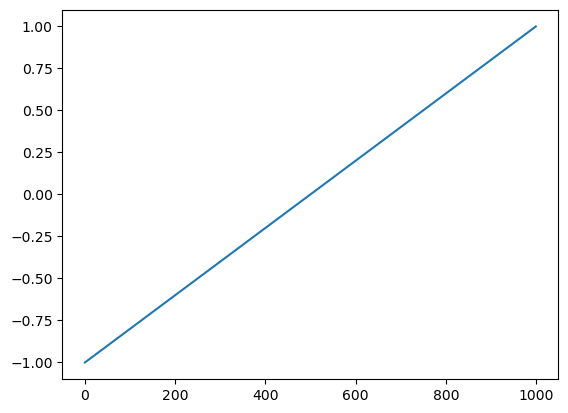

In [9]:
#t,x = get_domain_points(key2,n=2000)
t,x = get_domain_points_lhs(n=1500)
bndry,f_bndry = get_bndry(xn=1000,tn=50)
print(t.shape,x.shape,bndry.shape,f_bndry.shape)
plt.plot(bndry[:,1])

In [10]:
@jax.jit
def KdV(params,t,x):
    def pred(params,t,x):
        out_e = jnp.eye(1,1,0).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    

    dx_pred = jax.grad(pred,argnums=2)
    dxx_pred = jax.grad(dx_pred,argnums=2)
    dxxx_pred = jax.grad(dxx_pred,argnums=2)
    dt_pred = jax.grad(pred,argnums=1)
    
    
    
    eqn = dt_pred(params,t,x) + pred(params,t,x)*dx_pred(params,t,x)+(0.0025)*dxxx_pred(params,t,x)
    
    return jnp.inner(eqn,eqn)/2.0




KdV(params,0.9,1.8)

Array(0.03031435, dtype=float32)

In [11]:
@jax.jit
def periodic(params,t,x):
    xr = 1.0
    out_e = jnp.eye(1,1,0).flatten()
    x1 = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)
    x2 = jnp.eye(1,2,0)*t - jnp.eye(1,2,1)
    f1 = model.apply(params,x1).flatten()
    f2 = model.apply(params,x2).flatten()
    return jnp.inner(f1-f2,f1-f2)

periodic(params,0.9,1.8)

Array(0.00668885, dtype=float32)

In [12]:
#k1,k2 = jax.random.split(key2)
#x_samples = random.normal(k1,(n_samp,xdim))
#f_samples = jnp.sin(x_samples[:,1]-x_samples[:,0])

In [13]:
@jax.jit
def mse(params,bndry,f_bndry,td,xd):
    
    def sq_loss(x,y):
        yp = model.apply(params,x)
        return jnp.inner((y-yp),(y-yp))/2.0
    def apply_diff_eq(t,x):
        return KdV(params,t,x)
    def apply_periodic(t,x):
        return periodic(params,t,x)
    
    return jnp.mean(jax.vmap(sq_loss)(bndry,f_bndry),axis=0) \
            + jnp.mean(jax.vmap(apply_diff_eq,in_axes=(0,0))(td,xd),axis=0)\
            + jnp.mean(jax.vmap(apply_periodic,in_axes=(0,0))(td,xd),axis=0)

        
    

In [14]:
3+3\
+2

8

In [15]:
print("loss is {}",mse(params,bndry,f_bndry,t,x))

loss is {} 0.36572254


In [16]:
loss_and_grad = jax.value_and_grad(mse)

In [17]:
@jax.jit
def update_params(params,grads,lr=0.1):
    param_u = jax.tree_util.tree_map(lambda p,g: p-lr*g,params,grads)
    return param_u

In [18]:
#for i in range(10001):
#    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
#    params = update_params(params,grd)
#    if i%10==0:
#        print(f"loss is {i}",loss)

In [17]:

tx = optax.adam(learning_rate=0.01)
optstate = tx.init(params) 

loss_min =1.0
for i in range(3000):
    #t,x=get_domain_points(key2,n=100)
    #key1,key2 = random.split(key2)
    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
    if loss_min>loss:
        params_best = params
        loss_min = loss
    updates,optstate = tx.update(grd,optstate)
    params = optax.apply_updates(params,updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss)
        
tx = optax.adam(learning_rate=0.001)
optstate = optstate#tx.init(params) 

for i in range(6000):
    #t,x=get_domain_points(key2,n=100)
    #key1,key2 = random.split(key2)
    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
    if loss_min>loss:
        params_best = params
        loss_min = loss
    updates,optstate = tx.update(grd,optstate)
    params = optax.apply_updates(params,updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss)
        
tx = optax.adam(learning_rate=0.0001)
optstate = optstate#tx.init(params) 

for i in range(60000):
    #t,x=get_domain_points(key2,n=100)
    #key1,key2 = random.split(key2)
    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
    if loss_min>loss:
        params_best = params
        loss_min = loss
    updates,optstate = tx.update(grd,optstate)
    params = optax.apply_updates(params,updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss)
        
print("best loss ",loss_min)

Loss step 0:  0.36572257
Loss step 50:  0.06998356
Loss step 100:  0.05051148
Loss step 150:  0.043257542
Loss step 200:  0.04477117
Loss step 250:  0.04953597
Loss step 300:  0.03783121
Loss step 350:  0.032512043
Loss step 400:  0.04617187
Loss step 450:  0.038077246
Loss step 500:  0.056310337
Loss step 550:  0.032918468
Loss step 600:  0.043036208
Loss step 650:  0.09369871
Loss step 700:  0.04890094
Loss step 750:  0.046130084
Loss step 800:  0.04168909
Loss step 850:  0.04132766
Loss step 900:  0.034606595
Loss step 950:  0.05557553
Loss step 1000:  0.039254233
Loss step 1050:  0.040179282
Loss step 1100:  0.055164747
Loss step 1150:  0.04601503
Loss step 1200:  0.0381073
Loss step 1250:  0.06260242
Loss step 1300:  0.04220757
Loss step 1350:  0.04768857
Loss step 1400:  0.052783787
Loss step 1450:  0.04261952
Loss step 1500:  0.043347158
Loss step 1550:  0.03483715
Loss step 1600:  0.028324937
Loss step 1650:  0.0329005
Loss step 1700:  0.05615928
Loss step 1750:  0.0528361
Loss

Loss step 5200:  0.002046294
Loss step 5250:  0.0020461674
Loss step 5300:  0.0020044206
Loss step 5350:  0.0019837797
Loss step 5400:  0.0019630294
Loss step 5450:  0.0019436689
Loss step 5500:  0.0019631295
Loss step 5550:  0.0019061689
Loss step 5600:  0.001969839
Loss step 5650:  0.0018690262
Loss step 5700:  0.0018501969
Loss step 5750:  0.0018334802
Loss step 5800:  0.001815155
Loss step 5850:  0.0017977343
Loss step 5900:  0.0017822805
Loss step 5950:  0.0017855517
Loss step 6000:  0.0017494576
Loss step 6050:  0.0017336798
Loss step 6100:  0.001717876
Loss step 6150:  0.0017031311
Loss step 6200:  0.0016881538
Loss step 6250:  0.0016732123
Loss step 6300:  0.0016584286
Loss step 6350:  0.0016451385
Loss step 6400:  0.0016812807
Loss step 6450:  0.00161769
Loss step 6500:  0.0016030503
Loss step 6550:  0.0015894333
Loss step 6600:  0.001617456
Loss step 6650:  0.0015628915
Loss step 6700:  0.0015498045
Loss step 6750:  0.0015366124
Loss step 6800:  0.0015285279
Loss step 6850:  

Loss step 18550:  0.0005515721
Loss step 18600:  0.00055034715
Loss step 18650:  0.0005492754
Loss step 18700:  0.00082755473
Loss step 18750:  0.00054837787
Loss step 18800:  0.00054577214
Loss step 18850:  0.00054461055
Loss step 18900:  0.00054353214
Loss step 18950:  0.0005426912
Loss step 19000:  0.0005412327
Loss step 19050:  0.0005669867
Loss step 19100:  0.00057993457
Loss step 19150:  0.0005527577
Loss step 19200:  0.0005382532
Loss step 19250:  0.000535883
Loss step 19300:  0.0005388211
Loss step 19350:  0.0005338148
Loss step 19400:  0.00053265976
Loss step 19450:  0.00053157273
Loss step 19500:  0.0005436828
Loss step 19550:  0.0005302965
Loss step 19600:  0.0005741468
Loss step 19650:  0.00052757864
Loss step 19700:  0.00054862356
Loss step 19750:  0.00052821514
Loss step 19800:  0.00052453193
Loss step 19850:  0.000523781
Loss step 19900:  0.00053369685
Loss step 19950:  0.00052159093
Loss step 20000:  0.00052055507
Loss step 20050:  0.00052212743
Loss step 20100:  0.0006

Loss step 31550:  0.0003923684
Loss step 31600:  0.00039201102
Loss step 31650:  0.00039162542
Loss step 31700:  0.0003912055
Loss step 31750:  0.00039081022
Loss step 31800:  0.0008760976
Loss step 31850:  0.00039252275
Loss step 31900:  0.00038973792
Loss step 31950:  0.000389325
Loss step 32000:  0.0004274924
Loss step 32050:  0.00038857386
Loss step 32100:  0.00042497253
Loss step 32150:  0.0003880745
Loss step 32200:  0.00038747583
Loss step 32250:  0.00066892273
Loss step 32300:  0.00038765607
Loss step 32350:  0.00038640565
Loss step 32400:  0.0003860017
Loss step 32450:  0.00046758368
Loss step 32500:  0.00038694474
Loss step 32550:  0.0003853902
Loss step 32600:  0.00038713895
Loss step 32650:  0.00038420237
Loss step 32700:  0.0003840232
Loss step 32750:  0.00039698184
Loss step 32800:  0.00038315522
Loss step 32850:  0.00038273385
Loss step 32900:  0.0003895488
Loss step 32950:  0.00038787245
Loss step 33000:  0.00038171108
Loss step 33050:  0.0003812754
Loss step 33100:  0.

Loss step 44500:  0.0003107737
Loss step 44550:  0.0003115671
Loss step 44600:  0.00031110787
Loss step 44650:  0.00030991843
Loss step 44700:  0.0003110762
Loss step 44750:  0.0003121251
Loss step 44800:  0.00030917444
Loss step 44850:  0.0003088984
Loss step 44900:  0.0003941483
Loss step 44950:  0.00031231358
Loss step 45000:  0.00036388947
Loss step 45050:  0.00030814612
Loss step 45100:  0.00030883873
Loss step 45150:  0.00031589007
Loss step 45200:  0.0003072579
Loss step 45250:  0.00030702478
Loss step 45300:  0.00032387738
Loss step 45350:  0.0003065145
Loss step 45400:  0.00030616194
Loss step 45450:  0.00034302476
Loss step 45500:  0.0003221097
Loss step 45550:  0.00031054503
Loss step 45600:  0.00030860433
Loss step 45650:  0.00036121422
Loss step 45700:  0.00030571563
Loss step 45750:  0.00041502737
Loss step 45800:  0.00030424006
Loss step 45850:  0.00031097207
Loss step 45900:  0.00030789254
Loss step 45950:  0.0003035119
Loss step 46000:  0.0003369148
Loss step 46050:  0

Loss step 57450:  0.0002590704
Loss step 57500:  0.00025850162
Loss step 57550:  0.0002739882
Loss step 57600:  0.00025806503
Loss step 57650:  0.0003392018
Loss step 57700:  0.00025847217
Loss step 57750:  0.00025736864
Loss step 57800:  0.00029741853
Loss step 57850:  0.00025712914
Loss step 57900:  0.00025689954
Loss step 57950:  0.00032926496
Loss step 58000:  0.00025695632
Loss step 58050:  0.00025644668
Loss step 58100:  0.0002562739
Loss step 58150:  0.00026616946
Loss step 58200:  0.00025683275
Loss step 58250:  0.00025586152
Loss step 58300:  0.00025568373
Loss step 58350:  0.00030317839
Loss step 58400:  0.00026469855
Loss step 58450:  0.0002606694
Loss step 58500:  0.00026077693
Loss step 58550:  0.00025565785
Loss step 58600:  0.0002549005
Loss step 58650:  0.0003076954
Loss step 58700:  0.00025489109
Loss step 58750:  0.00025429338
Loss step 58800:  0.00041493008
Loss step 58850:  0.00025410755
Loss step 58900:  0.0002538637
Loss step 58950:  0.0006367069
Loss step 59000: 

In [21]:
import pickle

with open('test_params_best.pickle', 'wb') as fp:
    pickle.dump(params_best, fp)

In [22]:
with open('test_params_best.pickle', 'rb') as fp:
    ptest = pickle.load(fp)

In [28]:
ptest

{'params': {'layers_0': {'bias': Array([-0.11532675,  0.17396015, -0.3883697 , -0.20231003, -0.48566753,
          -0.48026368, -1.0599167 , -0.0491545 , -0.08777686,  0.42287472,
          -0.67376053,  0.3171077 , -0.37236446, -0.38454035,  0.28144455,
          -0.03757121, -0.22277308,  0.4201485 ,  0.49588892,  0.06954277],      dtype=float32),
   'kernel': Array([[ 0.09627046, -0.09854875,  0.22751126, -0.3324655 ,  0.14383772,
            0.5438976 , -0.1911745 ,  0.8452209 , -0.03106351,  0.14843953,
            0.77084804, -0.02687593, -0.37936944,  0.2342143 , -0.6106523 ,
            0.10209137, -0.12554236, -0.22583412,  0.36431518, -0.45766446],
          [ 0.09451703,  0.05492829, -1.0788728 , -0.24892186, -1.1097534 ,
           -0.26568994,  0.40165573,  0.6471799 , -0.28750956, -0.7895293 ,
           -0.8211183 , -0.5121013 ,  0.5834311 ,  0.58742094, -0.21748683,
            0.44080746,  1.3778956 , -0.71705014, -1.6684158 , -0.15708748]],      dtype=float32)},
  'la

In [29]:
params_best

{'params': {'layers_0': {'bias': Array([-0.11532675,  0.17396015, -0.3883697 , -0.20231003, -0.48566753,
          -0.48026368, -1.0599167 , -0.0491545 , -0.08777686,  0.42287472,
          -0.67376053,  0.3171077 , -0.37236446, -0.38454035,  0.28144455,
          -0.03757121, -0.22277308,  0.4201485 ,  0.49588892,  0.06954277],      dtype=float32),
   'kernel': Array([[ 0.09627046, -0.09854875,  0.22751126, -0.3324655 ,  0.14383772,
            0.5438976 , -0.1911745 ,  0.8452209 , -0.03106351,  0.14843953,
            0.77084804, -0.02687593, -0.37936944,  0.2342143 , -0.6106523 ,
            0.10209137, -0.12554236, -0.22583412,  0.36431518, -0.45766446],
          [ 0.09451703,  0.05492829, -1.0788728 , -0.24892186, -1.1097534 ,
           -0.26568994,  0.40165573,  0.6471799 , -0.28750956, -0.7895293 ,
           -0.8211183 , -0.5121013 ,  0.5834311 ,  0.58742094, -0.21748683,
            0.44080746,  1.3778956 , -0.71705014, -1.6684158 , -0.15708748]],      dtype=float32)},
  'la

(200, 2)


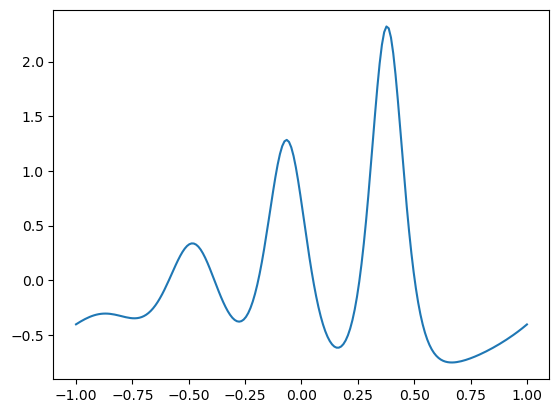

In [19]:
key,key1= random.split(key)
xx = jnp.linspace(-1.0,1.0,200)
tt=0.8
dmn = jnp.stack((tt*jnp.ones_like(xx),xx),axis=1)
print(dmn.shape)
f = model.apply(params_best,dmn)
plt.plot(xx,f)
#dmn

In [31]:
xs = jnp.linspace(-2.0,2.0,100).reshape((100))
ts = jnp.linspace(-2.0,2.0,100).reshape((100))
d = jnp.stack([ts,xs],axis=1)
ff = jnp.array([99.0,99.0])
print(ff.shape)
td = d - ff
print(td.shape)
print(d[:2,:],"djcdj",td[:2,:])

(2,)
(100, 2)
[[-2.        -2.       ]
 [-1.9595959 -1.9595959]] djcdj [[-101.       -101.      ]
 [-100.959595 -100.959595]]


In [ ]:
@jax.jit
def D_x(params,xin):
    argn = 1
    t = xin[:,0]
    x = xin[:,1]
    def pred(params,t,x):
        out_e = jnp.eye(1,1,0).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    
    d_pred = jax.grad(pred,argnums=argn)
    return jax.vmap(d_pred,in_axes=(None,0,0))(params,t,x)


def D2_tx(d_in_i,d_out_i=0,xdim=2,fdim=1):
    argn = d_in_i+1
    def pred(params,t,x):
        out_e = jnp.eye(1,fdim,d_out_i).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    
    d_pred = jax.grad(jax.grad(pred,argnums=argn),argnums=argn)
    return jax.vmap(d_pred,in_axes=(None,0,0))

  

In [ ]:
@jax.jit
def mse(params,x_batch,y_batch):
    def sq_loss(x,y):
        yp = model.apply(params,x)
        return jnp.inner((y-yp),(y-yp))/2.0
    
    return jnp.mean(jax.vmap(sq_loss)(x_batch,y_batch),axis=0)
        